In [1]:
%matplotlib inline

# import dependencies
from matplotlib import style
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

style.use('fivethirtyeight')

# Reflect Tables into SQLAlchemy

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine('sqlite:///Resources/hawaii.sqlite')

In [4]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
# Inspect structure of measurement, station tables
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])
    
print("--------------")
    
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

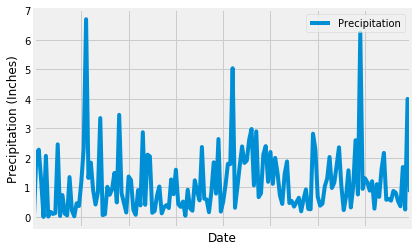

In [9]:
# Calculate the date 1 year ago from the last data point in the database
lastDate = session.query(func.max(Measurement.date)).one()[0]
lastDate = dt.strptime(lastDate, '%Y-%m-%d')
yearFromLast = lastDate - relativedelta(years = 1)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= yearFromLast).all()

# Unpack tuples using list comprehensions
date = [result[0] for result in results]
prcp = [result[1] for result in results]

# Save the query results as a Pandas DataFrame and set the index to the date column
lastYrPrecip = pd.DataFrame({'Date': date, 'Precipitation': prcp})
lastYrPrecip = lastYrPrecip.set_index('Date')

# Clean up NaN values, duplicates
lastYrPrecip = lastYrPrecip.fillna(0)
lastYrPrecip = lastYrPrecip.drop_duplicates()

# Sort dataframe by date
lastYrPrecip = lastYrPrecip.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
lastYrPrecip.plot()

plt.tick_params(axis='x', which='both', labelbottom=False)
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")

plt.show()

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
lastYrPrecip.describe()

,Precipitation
count,160.000000
mean,1.144438
std,1.075791
min,0.000000
25%,0.397500
50%,0.855000
75%,1.637500
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.station)]
session.query(*sel).group_by(Measurement.station).all()

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station,
      func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]
session.query(*sel).group_by(Measurement.station).filter(Measurement.station == 'USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

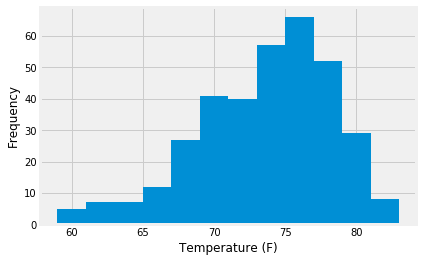

In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= yearFromLast).\
    filter(Measurement.station == 'USC00519281').\
    all()

# Unpack tuples using list comprehensions
date = [result[0] for result in results]
tobs = [result[1] for result in results]

# Save the query results as a Pandas DataFrame and set the index to the date column
lastYrTemps = pd.DataFrame({'Date': date, 'Temperature': tobs})
lastYrTemps = lastYrTemps.set_index('Date')

# Clean up NaN values, duplicates
lastYrTemps = lastYrTemps.fillna(0)

# Sort dataframe by date
lastYrTemps = lastYrTemps.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
lastYrTemps["Temperature"].hist(bins = 12)

plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")

plt.show()